## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

episodes_df = pd.read_csv("data/simpsons_episodes.csv", index_col="id").sort_index()
text_df = pd.read_csv("data/simpsons_script_lines.csv", error_bad_lines=False).sort_index()

b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

## Get main characters

In [2]:
main_characters = list(text_df["raw_character_text"].value_counts().index[:15])

## Make plots
Disclaimer after publication: This is not a statistically sound approach to access the influence of a character, as we would need to check the p-values of the coefficients of Linear Regression whether the relationship is valid.

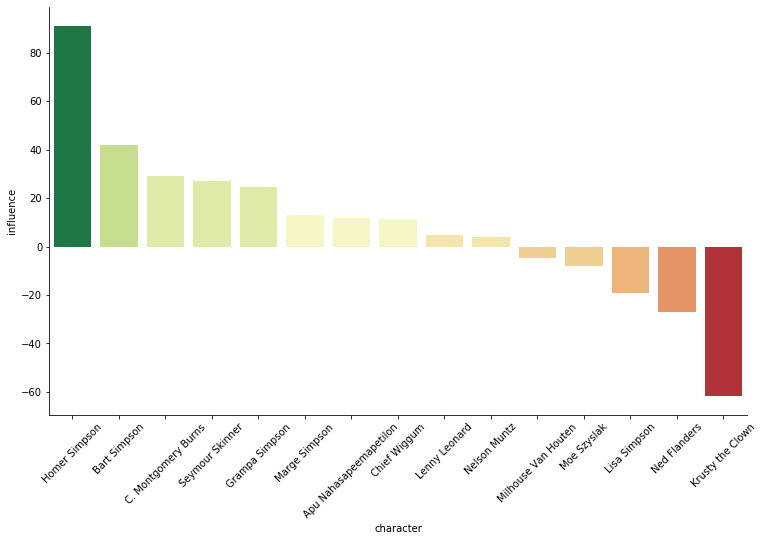

In [2]:

data_df = episodes_df["imdb_rating"].copy().to_frame()
data_df = data_df.iloc[:568] # not all episode data here, rest is NaN
bins = [0,6,8,10]
data_df["label"] = pd.cut(data_df["imdb_rating"], bins=bins, labels=np.arange(len(bins)-1)) # classify each value as 0,1,2 (bad, medium, good)

for character in main_characters:
    character_text_df = text_df[text_df["raw_character_text"] == character].groupby("episode_id").sum()["word_count"].to_frame()
    character_text_df.index.name = "id"
    character_text_df.columns = [character]
    data_df = pd.concat((data_df, character_text_df), axis=1)

data_df = data_df.groupby("label").mean()

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 7.5)
sns.despine()
plt.xticks(rotation=45)

X = data_df.index.to_numpy().reshape(-1,1)
coefs = []
for character in main_characters:
    y = data_df[character].to_numpy()
    model = LinearRegression().fit(X, y)
    coefs.append(model.coef_[0])

influence_df = pd.DataFrame({"character": main_characters, "influence": coefs}).sort_values("influence", ascending=False)

# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
def colors_from_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, 15)
    return np.array(palette).take(indices, axis=0)

sns.barplot(x=influence_df["character"], y=influence_df["influence"], ax=ax, palette=colors_from_values(influence_df["influence"], "RdYlGn"))
fig.savefig("influence.png")